In [6]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_explain.nn.concepts import ConceptReasoningLayer
from torch_explain import datasets
import torch_explain as te

In [7]:
import matplotlib.pyplot as plt

def plot_feature_importance_aggregated(model):
    importance = model.feature_importances_

    # Aggregate the feature importance by the categorical variables
    feature_importances = {}
    for feature_name, importance in zip(df.columns, importance):
        feature_name = feature_name.split("_")[1] if "_" in feature_name else feature_name
        if feature_name in feature_importances:
            feature_importances[feature_name] += importance
        else:
            feature_importances[feature_name] = importance

    # Sort the feature importance
    feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=False))

    #Plot the feature importance
    y_values = list(feature_importances.keys())
    x_values = list(feature_importances.values())
    plt.barh(y_values, x_values, color='blue')
    plt.xlabel("Feature importance")
    plt.ylabel("Concepts")
    plt.title("Feature importance aggregated by concept")

    # Add numerical values on the bar plot
    for index, value in enumerate(x_values):
        plt.text(value - 0.05, index, str(round(value, 3)), color='white', va='center')

    plt.show()

XOR dataset

x: torch.Size([150000, 2]), c: torch.Size([150000, 2]), y: torch.Size([150000, 2])


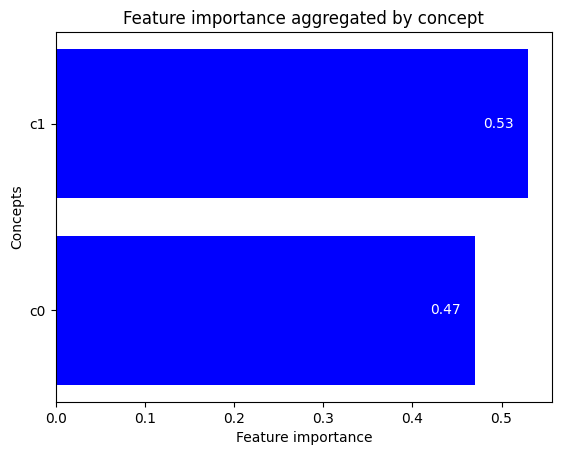

In [8]:
#Load the dataset
x, c, y = datasets.xor(150000)
y = F.one_hot(y.long().ravel()).float()
print(f'x: {x.shape}, c: {c.shape}, y: {y.shape}')

#Load the model
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)
task_predictor = ConceptReasoningLayer(embedding_size, y.shape[1])
model = torch.nn.Sequential(concept_encoder, task_predictor)

model.load_state_dict(torch.load('model_state_dict_DCRBase_XOR.pth'))
cem = model[0]
dcr = model[1]

#Create the dataframe
cem.eval()
c_emb , c_pred = cem(x)
y_pred_dt, sign_attn_dt, filter_attn_dt = dcr(c_emb, c_pred, return_attn=True)

from torch_explain.nn.semantics import GodelTNorm
logic = GodelTNorm()
values_dt = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
sign_terms_dt = logic.iff_pair(sign_attn_dt, values_dt)

sign_concept_0 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,0,:]])
sign_concept_1 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,1,:]])
filter_concept_0 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,0,:]])
filter_concept_1 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,1,:]])

final_features = np.hstack((sign_concept_0, filter_concept_0, sign_concept_1, filter_concept_1))
names = ['sign_c0_y0', 'sign_c0_y1', 'filter_c0_y0', 'filter_c0_y1', 'sign_c1_y0', 'sign_c1_y1', 'filter_c1_y0', 'filter_c1_y1']
df = pd.DataFrame(final_features, columns=names)

#Permutation feature importance
from sklearn.tree import DecisionTreeClassifier #RandomForestClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(c_emb.detach().numpy().argmax(axis=1), y_pred_dt.detach().numpy().argmax(axis=1))
plot_feature_importance_aggregated(dt_clf)

Trigonometry dataset

x: torch.Size([150000, 7]), c: torch.Size([150000, 3]), y: torch.Size([150000, 2])


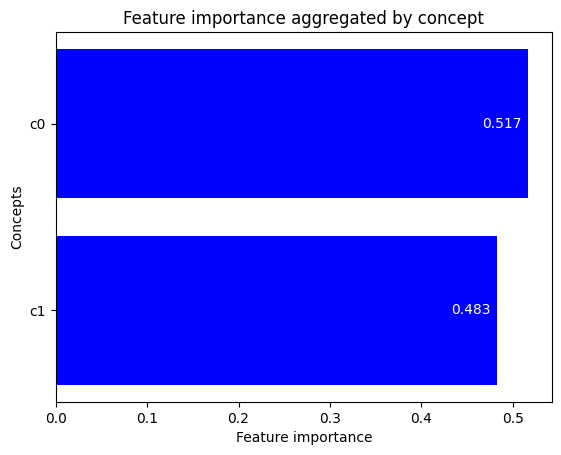

In [9]:
#Load the dataset
x, c, y = datasets.trigonometry(150000)
y = F.one_hot(y.long().ravel()).float()
print(f'x: {x.shape}, c: {c.shape}, y: {y.shape}')

#Load the model
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)
task_predictor = ConceptReasoningLayer(embedding_size, y.shape[1])
model = torch.nn.Sequential(concept_encoder, task_predictor)

model.load_state_dict(torch.load('model_state_dict_DCRBase_trigonometry.pth'))
cem = model[0]
dcr = model[1]

#Create the dataframe
cem.eval()
c_emb , c_pred = cem(x)
y_pred_dt, sign_attn_dt, filter_attn_dt = dcr(c_emb, c_pred, return_attn=True)

from torch_explain.nn.semantics import GodelTNorm
logic = GodelTNorm()
values_dt = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
sign_terms_dt = logic.iff_pair(sign_attn_dt, values_dt)

sign_concept_0 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,0,:]])
sign_concept_1 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,1,:]])
sign_concept_2 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,2,:]])
filter_concept_0 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,0,:]])
filter_concept_1 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,1,:]])
filter_concept_2 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,2,:]])

final_features = np.hstack((sign_concept_0, filter_concept_0, sign_concept_1, filter_concept_1, sign_concept_2, filter_concept_2))
names = ['sign_c0_y0', 'sign_c0_y1', 'filter_c0_y0', 'filter_c0_y1', 'sign_c1_y0', 'sign_c1_y1', 'filter_c1_y0', 'filter_c1_y1', 'sign_c2_y0', 'sign_c2_y1', 'filter_c2_y0', 'filter_c2_y1']
df = pd.DataFrame(final_features, columns=names)

#Permutation feature importance
from sklearn.tree import DecisionTreeClassifier #RandomForestClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(c_emb.detach().numpy().argmax(axis=1), y_pred_dt.detach().numpy().argmax(axis=1))
plot_feature_importance_aggregated(dt_clf)

Dot dataset

x: torch.Size([150000, 4]), c: torch.Size([150000, 2]), y: torch.Size([150000, 2])


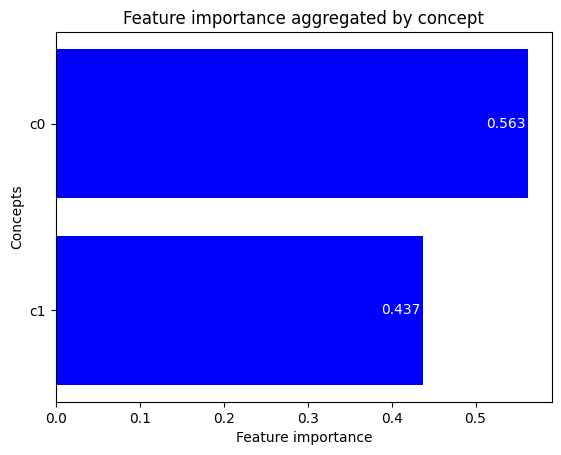

In [10]:
#Load the dataset
x, c, y = datasets.dot(150000)
y = F.one_hot(y.long().ravel()).float()
print(f'x: {x.shape}, c: {c.shape}, y: {y.shape}')

#Load the model
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)
task_predictor = ConceptReasoningLayer(embedding_size, y.shape[1])
model = torch.nn.Sequential(concept_encoder, task_predictor)

model.load_state_dict(torch.load('model_state_dict_DCRBase_dot.pth'))
cem = model[0]
dcr = model[1]

#Create the dataframe
cem.eval()
c_emb , c_pred = cem(x)
y_pred_dt, sign_attn_dt, filter_attn_dt = dcr(c_emb, c_pred, return_attn=True)

from torch_explain.nn.semantics import GodelTNorm
logic = GodelTNorm()
values_dt = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
sign_terms_dt = logic.iff_pair(sign_attn_dt, values_dt)

sign_concept_0 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,0,:]])
sign_concept_1 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,1,:]])
filter_concept_0 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,0,:]])
filter_concept_1 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,1,:]])

final_features = np.hstack((sign_concept_0, filter_concept_0, sign_concept_1, filter_concept_1))
names = ['sign_c0_y0', 'sign_c0_y1', 'filter_c0_y0', 'filter_c0_y1', 'sign_c1_y0', 'sign_c1_y1', 'filter_c1_y0', 'filter_c1_y1']
df = pd.DataFrame(final_features, columns=names)

#Permutation feature importance
from sklearn.tree import DecisionTreeClassifier #RandomForestClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(c_emb.detach().numpy().argmax(axis=1), y_pred_dt.detach().numpy().argmax(axis=1))
plot_feature_importance_aggregated(dt_clf)